In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch

from allensdk.brain_observatory.ecephys.ecephys_project_cache \
    import EcephysProjectCache

from eigvec.gabor import GaborLearner

# Learning Gabors

A set of Gabors can decompose images. This requires setting the number of Gabors and the size of each Gabor or the size of each image window. The idea is that a large enough set can universally represent a set of images. Gabors will have the following shape:

$$
\text{dim}(G) = (\text{n\_gabors}, \text{gabor\_shape}_i, \text{gabor\_shape}_j)
$$

An image or set of images can be reshaped into non-overlapping sub-windows. Each windows has a set of weights the same length and number of gabors:

$$
\text{dim}(W) = (\text{n\_windows}, \text{n\_gabors})
$$

The product between the gabors and gabor weights, should produce the image:

$$
\hat{X}_i = W G 
$$

Here, mean-squared error is used as the loss function. Later, a sparse penalty will be added.

$$
\begin{align*}
L(G, W) &= \frac{1}{n} \sum_{i=0}^n (X_i - WG)^2 \\
&= \frac{1}{n} \sum_{i=0}^n (X_i - \hat{X}_i)^2
\end{align*}
$$

In [2]:
# Load natural scene
cache = EcephysProjectCache.from_warehouse()
scene = cache.get_natural_scene_template(1)

# To f32 tensor
X = scene[:896, :1152]
X = torch.from_numpy(X).float()

In [3]:
# Gabor settings
window_length = 8
n_gabors = 64
lr = 1e-2
verbose = 100

# Learn gabors
gl = GaborLearner(window_length, n_gabors, lr=lr,
                  n_epochs=2500, verbose=verbose)
gl.fit(X)

/Users/ryanhammonds/projects/convolutional_ar/.env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch 2400, loss: 0.012766609899699688


In [4]:
# Each image sub-window has 64 weights
print(gl.model_.gabor_weights.shape)

# The weights scale the set of 64, 8x8 gabors
print(gl.model_.gabors().shape)

torch.Size([16128, 64])
torch.Size([64, 8, 8])


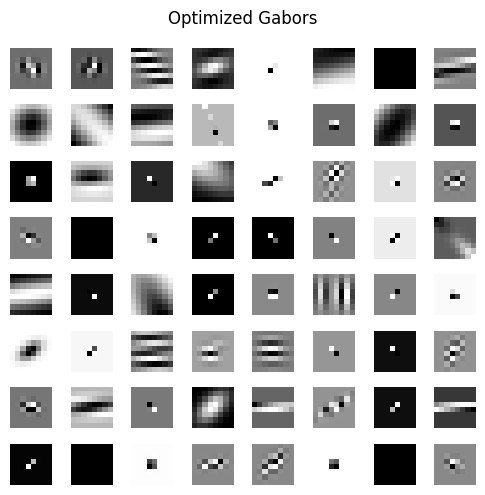

In [5]:
# Plot learned gabors
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(5, 5))
axes = axes.flatten()

vecs = gl.model_.gabors().detach().numpy()
for i in range(64):
    axes[i].imshow(vecs[i], cmap='gray')
    axes[i].axis("off")

fig.suptitle("Optimized Gabors")
plt.tight_layout()

## Sparsity

Previously, 64 gabors, $G$ were used to reconstruct each subwindow. 36 weights, $W$ were learned per image sub-window. These weights may be optimized to be sparse by adding an L1-penalty to the mean-squared error loss.

$$
\begin{align*}
L(W, G) &= \text{MSE}(X, \hat{X}) + ||W||_1 \\
&= \text{MSE}(X, \hat{X}) + \sum_{i=0}^{n} |w_i|
\end{align*}
$$

Sparsity can improve interpretability, acting as a form of feature selection. This comes at computational costs and a potentially non-convex loss surface. To achieve comparable results to the non-sparse model, 4x the number of epochs are required.

In [6]:
# Learn sparse gabors
gl_sparse = GaborLearner(window_length, n_gabors, lr=lr,
                         n_epochs=10_000, l0_penalty=0.01, verbose=verbose)
gl_sparse.fit(X)

epoch 9900, loss: 0.025256216526031494, penalty: 0.43787509202957153


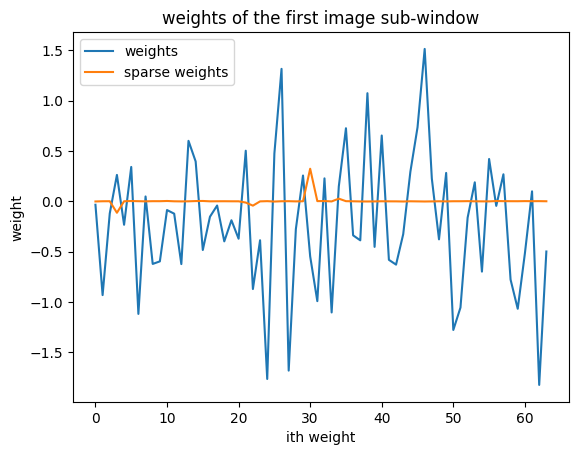

In [7]:
plt.title("weights of the first image sub-window")
plt.plot(gl.model_.gabor_weights[0].detach().numpy(), label="weights")
plt.plot(gl_sparse.model_.gabor_weights[0].detach().numpy(), label="sparse weights")
plt.xlabel("ith weight")
plt.ylabel("weight")
plt.legend();

In [8]:
# L1 penalty minimized during sparse optimization
print(f"L1 penalty (non-sparsely optimized): {float(torch.norm(gl.model_.gabor_weights, 1))}")
print(f"L1 penalty (sparsely optimized)    : {float(torch.norm(gl_sparse.model_.gabor_weights, 1))}")

L1 penalty (non-sparsely optimized): 730917.8125
L1 penalty (sparsely optimized)    : 130484.453125


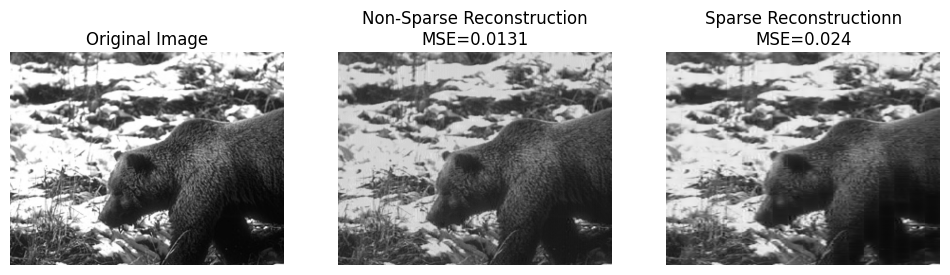

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

X_orig = X.reshape(896, 1152)
X_pred_nonsparse = gl.model_().detach().numpy().reshape(896, 1152)
X_pred_sparse = gl_sparse.model_().detach().numpy().reshape(896, 1152)

def normalize(X):
    return (X-X.mean())/X.std()

X_orig = normalize(X_orig)
X_pred_nonsparse = normalize(X_pred_nonsparse)
X_pred_sparse = normalize(X_pred_sparse)

axes[0].imshow(X_orig, cmap='gray')
axes[1].imshow(X_pred_nonsparse, cmap='gray')
axes[2].imshow(X_pred_sparse, cmap='gray')

for ax in axes:
    ax.axis("off")

mse_nonsparse = round(float(((X_orig - X_pred_nonsparse)**2).mean()), 4)
mse_sparse =  round(float(((X_orig - X_pred_sparse)**2).mean()), 4)

axes[0].set_title("Original Image")
axes[1].set_title(f"Non-Sparse Reconstruction\nMSE={mse_nonsparse}")
axes[2].set_title(f"Sparse Reconstructionn\nMSE={mse_sparse}");